## Preamble/setup

In [1]:
import os
import shutil
import time
import cv2
import random
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from fractions import Fraction

import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, Subset, RandomSampler, DataLoader, ConcatDataset

import utils

In [2]:
# Option for whether to only plot the results from saved scores, or to recalculate from scratch.
# Note this is very slow, but allows reproduction of all results
recalculate_results = False

device_name = utils.get_device()
device = torch.device(device_name)
CNN_params_dict = utils.CNN_params_setup(device)
dropout_conv, dropout_fc = CNN_params_dict['dropout_conv'], CNN_params_dict['dropout_fc']

In [3]:
## Plotting parameters for uniformity
my_fig_size = (7,6) # figure size
ms = 10 # marker size
lw = 4 # line width
title_size = 18
label_size = 14
legend_size = 10

## Original data CNN learning curve

In [4]:
# if recalculate_results: 
# Load the CIFAR-10 data to memory
full_cifar_dataset = CIFAR10
# Define data transformations
transform = transforms.Compose([transforms.ToTensor(),]) # Convert PIL Image to PyTorch Tensor

train_dataset = full_cifar_dataset(
    root=f'./{"data/cifar-10-orig"}',  # Change the root directory as needed
    train=True,      # Set to True for the training set
    transform=transform,
    download=True)

test_dataset = full_cifar_dataset(
    root=f'./{"data/cifar-10-orig"}',  # Change the root directory as needed
    train=False,     # Set to False for the test set
    transform=transform,
    download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Setup our main n_orig = 1024 sample
N = 1024

seed = 42
random.seed(seed)

random_indices = random.sample(range(len(train_dataset)), N)
train_samp = Subset(train_dataset, random_indices)
# Separate the images and labels
images_samp = torch.stack([train_samp[i][0] for i in range(N)])  # Stack the image tensors
labels_samp = torch.tensor([train_samp[i][1] for i in range(N)])  # Convert labels to a tensor

# Return as TensorDataset
subset_train_dataset = TensorDataset(images_samp, labels_samp)

### Baseline classification accuracy

In [6]:
# takes about 1 min per repeat to run (on my gpu)
if recalculate_results:
    repeats = 25
    baseline_scores_list = []
    for i in range(repeats):
        print(f"Calculating baseline scores, repeat {i + 1} of {repeats}")
        baseline_model = utils.Cifar_CNN(num_channels = 3, classes = 10, dropout_conv = dropout_conv, dropout_fc = dropout_fc).to(device)

        _, _, test_score = utils.nn_trainer(baseline_model, subset_train_dataset, test_dataset, opt_type = "adam", 
                CNN_params_dict = CNN_params_dict, loss_type = "nll", lr_sched = None, device_str = device_name, verbose = False)
        
        baseline_scores_list += [test_score]  
        end_time = time.time()

    avg_baseline_accuracy = np.mean(baseline_scores_list)
    print(f"Baseline classification accuracy: {avg_baseline_accuracy}")
else:
    avg_baseline_accuracy = 0.42261 # score hard-coded from full run (easier than saving to a separate file)

In [7]:
# takes about 6 hours to run on my gpu
orig_lc_json_name = "scores/orig_data_learning_curve.json"

if recalculate_results:
    n_samp = [1000, 2000, 4000, 8000, 15000, 30000, 50000]
    epoch_list = [20, 30, 50, 70, 100]
    lc_orig_dict = {}

    for j, e in enumerate(epoch_list):
        lc_orig_dict[f"Epochs = {e}"] = {}
        lc_CNN_params_dict = CNN_params_dict
        lc_CNN_params_dict['epochs'] = e
        for i in range(len(n_samp)):
            start_time = time.time()

            n = n_samp[i]
            random_indices = random.sample(range(len(train_dataset)), n)
            lc_train_samp = Subset(train_dataset, random_indices)
            # Separate the images and labels
            images = torch.stack([lc_train_samp[i][0] for i in range(n)])  # Stack the image tensors
            labels = torch.tensor([lc_train_samp[i][1] for i in range(n)])  # Convert labels to a tensor

            # Return as TensorDataset
            lc_subset_train_dataset = TensorDataset(images, labels)

            lc_model = utils.Cifar_CNN(num_channels = 3, classes = 10, dropout_conv = dropout_conv, dropout_fc = dropout_fc).to(device)

            _, _, test_score = utils.nn_trainer(lc_model, lc_subset_train_dataset, test_dataset, opt_type = "adam", 
                    CNN_params_dict=lc_CNN_params_dict, loss_type = "nll", lr_sched = None, device_str = device_name, verbose = False)
            
            lc_orig_dict[f"Epochs = {e}"][n] = test_score  
            end_time = time.time()
            print(f"Run {i + 1} out of {len(n_samp)} samples and {j+1} out of {len(epoch_list)} epochs, for {n} samples and {e} epochs. Test score = {round(test_score, 3)}. Runtime = {round(end_time - start_time, 1)} seconds")
            
    with open(orig_lc_json_name, 'w') as json_file:
        json.dump(lc_orig_dict, json_file)
else:
    with open(orig_lc_json_name, 'r') as json_file:
            lc_orig_dict = json.load(json_file)

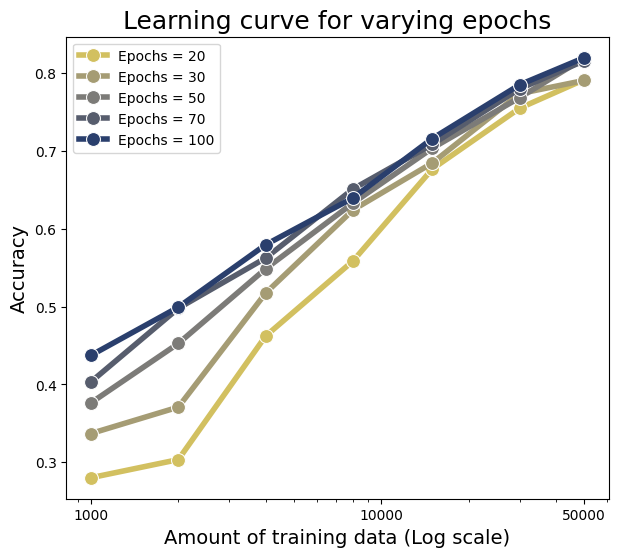

In [8]:
# Prepare the data for seaborn
data_list = []
for epochs, data in lc_orig_dict.items():
    for amount, accuracy in data.items():
        data_list.append({'Epochs': epochs, 'Amount': int(amount), 'Accuracy': accuracy})

df = pd.DataFrame(data_list)

# Create the plot
plt.figure(figsize=my_fig_size)
sns.lineplot(data=df, x='Amount', y='Accuracy', hue='Epochs', marker='o', markersize = ms, linewidth = lw, palette='cividis_r')

# Set log scale for x-axis
plt.xscale('log')

plt.xlabel("Amount of training data (Log scale)", fontsize=label_size)
plt.ylabel("Accuracy", fontsize=label_size)
plt.title("Learning curve for varying epochs", fontsize=title_size)
xticks = [1000, 10000, 50000]
plt.xticks(xticks, labels=[str(x) for x in xticks])
plt.legend(fontsize=legend_size)
plt.show()

## Conventional transformation image samples

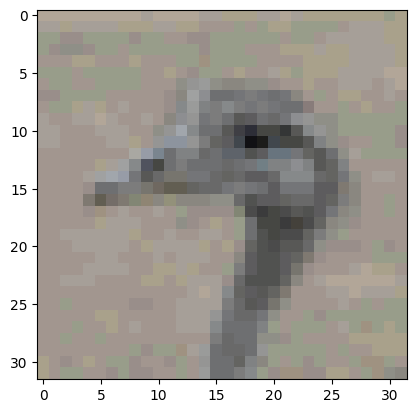

In [9]:
test_img = cv2.imread('data/bird_example.png')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.imshow(test_img)
plt.show()

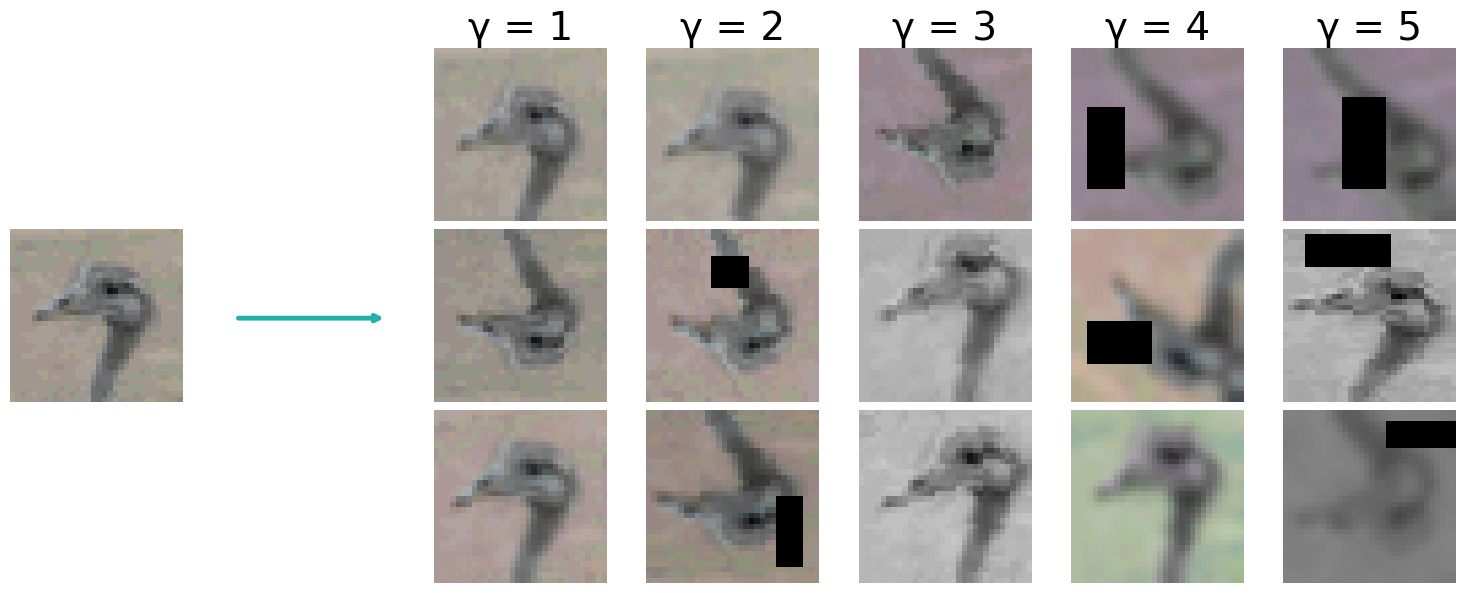

In [46]:
### Standard
nrow = 3
ncol = 7
fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
plt.subplots_adjust(hspace=-0.61, wspace=-0.4)
for i in range(nrow):
    for j in range(ncol):
        ax = axes[i, j]
        if j == 0:
            ax.imshow(np.ones((32, 32, 3)))  # White image
            if i == 1:
                ax.imshow(test_img)
            ax.axis('off')
        elif j == 1:
            ax.imshow(np.ones((32, 32, 3)))  # White image
            if i == 1:
                ax.annotate('', xy=(2, 16), xytext=(30, 16), arrowprops=dict(arrowstyle='<-', lw=3.5, color='lightseagreen'))
            ax.axis('off')
        elif j >= 2:
            gamma = j - 1
            img = utils.img_transformation(torch.tensor(test_img).T, prob = 1, gamma = gamma, seed = (53 + (i * j))).T
            ax.imshow(img)
            if i == 0:
                ax.set_title(f"γ = {gamma}", fontsize=28) 
            ax.axis('off')
fig.tight_layout()
plt.show()

## Conventional transformation optimisation
### Accuracy vs intensity gamma

In [11]:
acc_conv_gamma_json_name = "scores/acc_vs_conv_gamma.json"

if recalculate_results:
    gamma_list = [0, 0.5, 1, 1.5, 2, 2.5, 3, 4, 5]
    alpha_list = [1.01, 1.5, 2.5, 4, 6, 10]

    test_accs_per_alpha_dict = {}
    repeats = 5
    real_accs_per_aug_ratio = {}
    for ind, alpha in enumerate(alpha_list):
        test_acc_repeats = []
        for i in range(repeats):
            start_time = time.time()
            i_test_acc_list = []

            for gamma in gamma_list:    
                cnn_model = utils.Cifar_CNN(num_channels = 3, classes = 10, dropout_conv = dropout_conv, dropout_fc = dropout_fc).to(device)
                _, _, test_score = utils.nn_trainer(cnn_model, subset_train_dataset, test_dataset, opt_type = "adam", CNN_params_dict=CNN_params_dict, 
                                                    loss_type = "nll", lr_sched = None, device_str = device_name, verbose = False, 
                                                    augmentation = True, aug_ratio = alpha, aug_var = gamma)
                i_test_acc_list += [test_score]
            test_acc_repeats += [i_test_acc_list]
            end_time = time.time()
            print(f"Run for alpha number {ind+1} out of {len(alpha_list)} ({alpha}) and repeat {i+1} of {repeats} complete (note each run tests {len(gamma_list)} gamma options). Runtime = {round(end_time - start_time, 1)} seconds")

        test_accs_per_alpha_dict[alpha] = test_acc_repeats
            
    with open(acc_conv_gamma_json_name, 'w') as json_file:
        json.dump(test_accs_per_alpha_dict, json_file)
else:
    with open(acc_conv_gamma_json_name, 'r') as json_file:
            test_accs_per_alpha_dict = json.load(json_file)

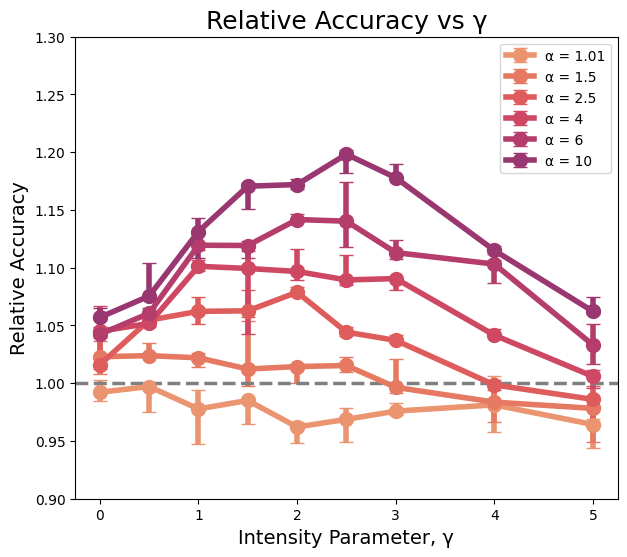

In [12]:
# x_axis = [-1] + var_list
alpha_list = list(test_accs_per_alpha_dict.keys())
gamma_list = [0, 0.5, 1, 1.5, 2, 2.5, 3, 4, 5]

# Prepare the data for seaborn
data_list = []
for alpha in alpha_list:
    this_accs = np.array(test_accs_per_alpha_dict[alpha])
    lq, med, uq = np.percentile(this_accs / avg_baseline_accuracy, [25, 50, 75], axis=0)
    lqd, uqd = med - lq, uq - med

    data_list.append({
        'Augmentation Ratio': alpha,
        'x': gamma_list,
        'Median Accuracy': med,
        'Lower Deviation': lqd,
        'Upper Deviation': uqd
    })

# Convert to DataFrame for easier plotting
df = pd.DataFrame(data_list)

# Create the plot
plt.figure(figsize=my_fig_size)
palette = sns.color_palette('flare', len(alpha_list)+2)

# Plot each augmentation ratio
for i, alpha in enumerate(alpha_list):
    plt.errorbar(df.loc[i, 'x'], df.loc[i, 'Median Accuracy'], 
                 yerr=[df.loc[i, 'Lower Deviation'], df.loc[i, 'Upper Deviation']], 
                 fmt='o-', label=f"α = {alpha}", capsize=5, color=palette[i], 
                 markersize = ms, linewidth = lw)

# Aesthetics
plt.title("Relative Accuracy vs γ", fontsize=title_size)
plt.ylim(0.9, 1.3)
plt.legend(fontsize=legend_size)
plt.xlabel("Intensity Parameter, γ", fontsize=label_size)
plt.ylabel("Relative Accuracy", fontsize=label_size)
plt.axhline(y=1, color='gray', linestyle='--', lw = 2.5)
plt.show()


In [13]:
gamma = 2.5

### Accuracy vs ratio alpha

In [14]:
gamma = 2.5
alphas = [1.5, 2.5, 5, 7, 10, 13, 16, 20, 25, 30, 35, 40, 50]
acc_conv_alpha_json_name = "scores/acc_vs_conv_alpha.json"

if recalculate_results:
    acc_aug_dict = {}
    N = 5
    for j in range(N):
        t0 = time.time()
        acc_per_rep_list = []
        for i, alpha in enumerate(alphas):
            print(f"Calculating scores for rep {j+1} of {N}, and alpha {i+1} of {len(alphas)}")
            ti = time.time()
            print(f"Calculating for alpha {i+1} out of {len(alphas)} ({alpha}), repeat {j+1} of {N}. Time so far = {round((ti-t0)/60, 1)} minutes.")
            cnn_mod = utils.Cifar_CNN(num_channels = 3, classes = 10, dropout_conv = dropout_conv, dropout_fc = dropout_fc).to(device)
            _, _, test_acc = utils.nn_trainer(cnn_model, subset_train_dataset, test_dataset, opt_type = "adam", CNN_params_dict=CNN_params_dict, 
                                                    loss_type = "nll", lr_sched = None, device_str = device_name, verbose = False, 
                                                    augmentation = True, aug_ratio = alpha, aug_var = gamma)
            acc_per_rep_list += [test_acc]
        acc_aug_dict[j] = acc_per_rep_list


    # Save the output dictionary to json file
    with open(acc_conv_alpha_json_name, 'w') as json_file:
        json.dump(acc_aug_dict, json_file)
else:
    with open(acc_conv_alpha_json_name, 'r') as json_file:
            acc_aug_dict = json.load(json_file)

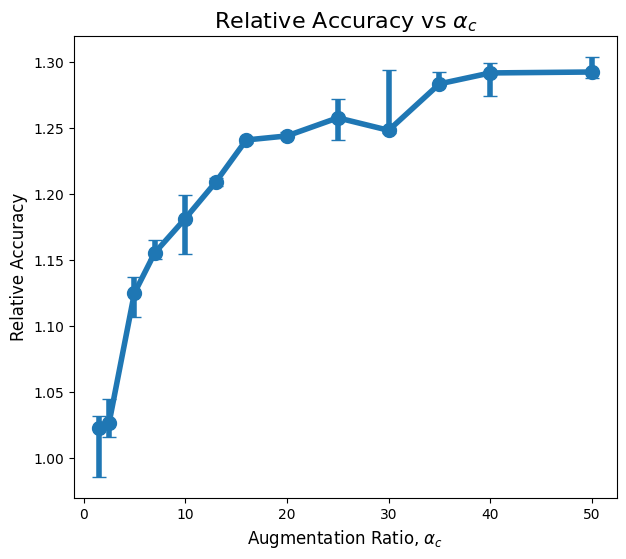

In [15]:
alphas = [1.5, 2.5, 5, 7, 10, 13, 16, 20, 25, 30, 35, 40, 50]
alpha_arr = np.array(list(acc_aug_dict.values()))
lq, med, uq = np.percentile(alpha_arr / avg_baseline_accuracy, [25, 50, 75], axis=0)
lqd, uqd = med - lq, uq - med

plt.figure(figsize=my_fig_size)

plt.errorbar(alphas, med, yerr=[lqd, uqd], fmt='o-', capsize=5, 
            markersize = ms, linewidth = lw,)
            # markeredgecolor='white', markeredgewidth=0.5, )

plt.ylabel("Relative Accuracy", fontsize=12)
plt.xlabel("Augmentation Ratio, $α_c$", fontsize=12)
plt.title("Relative Accuracy vs $α_c$", fontsize=16)
# plt.annotate(f"Error bars showing median & IQR across {len(acc_aug_dict)} tests", 
#              xy=(0.5, 0.97), xycoords='axes fraction', 
#              fontsize=10, ha='center', va='center')
# plt.grid(True)  # Add grid for better readability
plt.show()

### Learning curve on full data with augmentation

In [39]:
gamma = 2.5
alphas = [None, 2, 5, 20, 50]
n_samp = [100, 200, 500, 1024, 2000, 4000, 8000, 15000, 30000, 50000]

aug_lc_dict_json_name = "scores/aug_acc_lc.json"

if recalculate_results:
    train_length = len(train_dataset)
    seed = 42
    random.seed(seed)
    aug_lc_dict = {}
    # Loop through the alphas (amount of augmented data to use)
    for j, alpha in enumerate(alphas):
        # Set up name and aug_lc_dict for this iteration depending on augmentation type
        aug_bool = alpha is not None
        if aug_bool:
            score_name = f"alpha = {alpha}"
        else:
            score_name = "No augmentation"
        aug_lc_dict[score_name] = {}

        # Loop through the data sample lengths
        for i, n in enumerate(n_samp):
            # Time the code
            start_time = time.time()
            
            # Sample the cifar data n times (n being the current number of samples for this iteration) without replacement
            random_indices = random.sample(range(train_length), n)
            # Organise into a dataset
            random_reals = [train_dataset[i] for i in random_indices]
            random_x, random_y = zip(*random_reals)  # Unzip data into separate lists
            lc_subset_train_dataset = TensorDataset(torch.stack(random_x), torch.tensor(random_y))
            
            cnn_mod = utils.Cifar_CNN(num_channels = 3, classes = 10, dropout_conv = dropout_conv, dropout_fc = dropout_fc).to(device)
            _, _, test_acc = utils.nn_trainer(cnn_mod, lc_subset_train_dataset, test_dataset, opt_type = "adam", CNN_params_dict=CNN_params_dict, 
                                                        loss_type = "nll", lr_sched = None, device_str = device_name, verbose = False, 
                                                        augmentation = aug_bool, aug_ratio = alpha, aug_var = gamma)
            aug_lc_dict[score_name][n] = test_acc  
            end_time = time.time()
            print(f"Run {(i+1) + (j)*(len(n_samp))} out of {len(n_samp) * len(alphas)} complete, for {n} samples and {score_name}. Test score = {round(test_acc, 3)}. Runtime = {round(end_time - start_time, 1)} seconds")

    # Save the output dictionary to json file
    with open(aug_lc_dict_json_name, 'w') as json_file:
        json.dump(aug_lc_dict, json_file)
else:
    with open(aug_lc_dict_json_name, 'r') as json_file:
        aug_lc_dict = json.load(json_file)

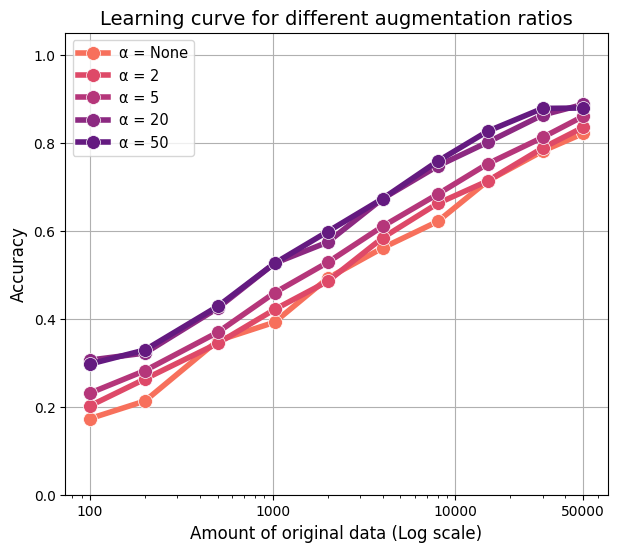

In [45]:
# Convert JSON dictionary to DataFrame
lc_df = pd.DataFrame(aug_lc_dict)
lc_df.reset_index(inplace=True)
lc_df.rename(columns={"index": "n_real"}, inplace=True)
lc_df["n_real"] = lc_df["n_real"].astype(int)
lc_df = lc_df.set_index("n_real")

# Create the plot
plt.figure(figsize=my_fig_size)

num_columns = len(lc_df.columns)
palette = sns.color_palette('magma_r', num_columns+4)

# Plot each column with a distinct color
for i, column in enumerate(lc_df.columns):
    # legend_entry = column.replace('α', '$α_c$')
    plt.semilogx(lc_df.index, lc_df[column], label=column, 
                 marker='o', color=palette[i+2], markersize=10, 
                 linewidth=4, markeredgecolor='white', markeredgewidth=0.5)

# Aesthetics
plt.xlabel("Amount of original data (Log scale)", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Learning curve for different augmentation ratios", fontsize=14)
plt.legend(fontsize=10.5)
xticks = [100, 1000, 10000, 50000]
plt.xticks(xticks, labels=[str(x) for x in xticks])
plt.ylim(0, 1.05)  # Set Y limits if needed
plt.grid(True)  # Add grid for better readability
plt.show()


## ImageGPT output samples

In [17]:
rep_sizes = [3]
prompt_sizes = {"small":0.25, "med":0.5, "large":0.75}
feature_extractor, model, clusters, device = utils.igpt_model_setup(device_name="cpu")

real_img = train_dataset[2993][0]

This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (1024). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


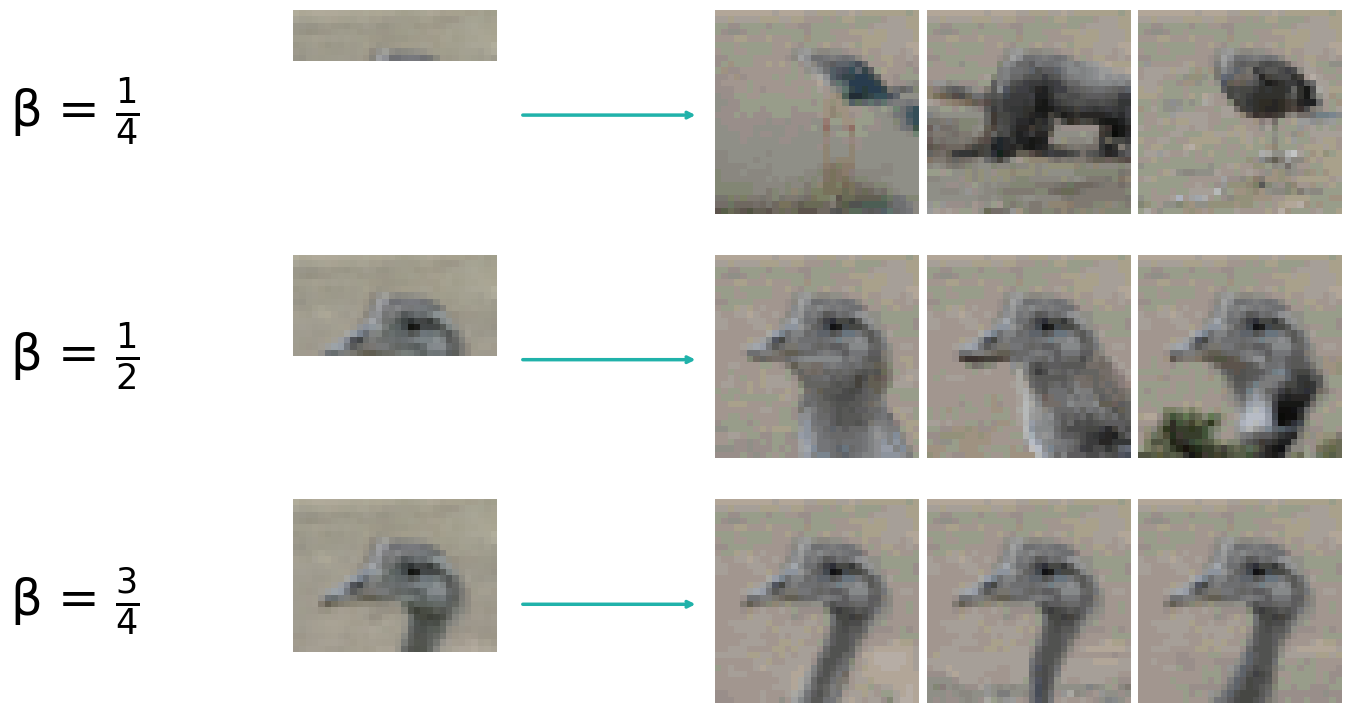

In [18]:
seed = 10

all_syn_imgs = utils.create_igpt_img(real_img, 32, feature_extractor, clusters, model, device, rep_sizes, prompt_sizes, return_img_dict = True, gen_seed = seed)
# Calculate the number of rows and columns
num_rows = len(all_syn_imgs)
num_cols = 5
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 3*num_rows))
plt.subplots_adjust(hspace=0.2, wspace=-0.7)

for i, (syn_set, item) in enumerate(all_syn_imgs.items()):
    for j in range(num_cols):
        ax = axes[i, j]
        if j == 0:
            if "small" in syn_set:
                frac = 0.25
            elif "med" in syn_set:
                frac = 0.5
            elif "large" in syn_set:
                frac = 0.75

            # Generate the white pixels
            white_pixels = torch.ones_like(real_img[:, :int((1 - frac) * 32), :])
            # Concatenate white pixels to the bottom of the original image
            extended_img = torch.cat([real_img[:, :int(frac * 32), :], white_pixels], dim=1)
            # Plot the extended image in the first column
            ax.imshow(extended_img.permute(1, 2, 0), aspect='equal')
            ax.axis('off')
            frac_str = fr"$\frac{{{Fraction(frac).limit_denominator().numerator}}}{{{Fraction(frac).limit_denominator().denominator}}}$"
            ax.text(-0.75, 0.5, f"β = {frac_str}", transform=ax.transAxes, rotation='horizontal',
                    verticalalignment='center', horizontalalignment='right', fontsize=36, color='black')
            # ax.text(-0.18, 0.5, "prompt", transform=ax.transAxes, rotation='horizontal',
            #         verticalalignment='center', horizontalalignment='right', fontsize=20, color='black')
        # Plot the white image with an arrow in the second column
        elif j == 1:
            ax.imshow(np.ones((32, 32, 3)))  # White image
            ax.annotate('', xy=(2, 16), xytext=(30, 16), arrowprops=dict(arrowstyle='<-', lw=2.5, color='lightseagreen'))
            ax.axis('off')
        # Plot the three images from the item list in columns 3, 4, and 5
        else:
            ax.imshow(item[j - 2].transpose(1, 2, 0))
            ax.axis('off')
# Show the figure
plt.show()

## GAN output samples

### Train the GANs

In [19]:
# ### need to do these GANs 1, 3, 6, 7
# parent_path = "data/paper_cifar_gan_aug_ratio_15.6/"
# parent_path = "data/paper_cifar_gan_aug_ratio_18.0_aug_var_1.8/"
# parent_path = "data/paper_cifar_gan_aug_ratio_10.0_aug_var_1/"
# parent_path = "data/paper_cifar_gan_aug_ratio_10.0_aug_var_0/"

In [20]:
# GAN option 1
# From Bayesian optimisation:
if recalculate_results:
    opt_gan_params = {
        'dropout_conv': 0.407,
        'gan_epochs': 791,
        'p_drop_disc': 0.453,
        'lr_gen': 2.64e-05,
        'lr_disc': 2.42e-05,
        'gan_aug_ratio': 15.6,
        'gan_aug_var': 0.0,
        'device_name': 'cuda',
        'save_name' : "models/gan_1"}

    other_params = {'device_name' : "mps", 'beta_1' : 0.5, 'beta_2' : 0.999999, 'gan_wd' : 0.0015, 'input_size' : 150,
                        'n_layers_gen' : 5, 'n_layers_disc' : 5, 'label_smoothing' : 0, 'disc_noise_std' : 0, 
                        'gan_val_split' : 0, 'gan_batch_size' : 64, 'loader_num_workers' : 0, 'test_reps' : 5}

    !python train_cifar_gan.py --dataset_name cifar10 --out_path {opt_gan_params['save_name']}      --save_type final  --samples 1024 --split_before_samp False      --epochs {opt_gan_params['gan_epochs']} \
        --lr_gen {opt_gan_params['lr_gen']}           --lr_disc {opt_gan_params['lr_disc']}         --beta_1 {other_params['beta_1']}             --beta_2 {other_params['beta_2']} \
        --wd {other_params['gan_wd']}                 --input_size {other_params['input_size']}     --n_layers_gen {other_params['n_layers_gen']} --n_layers_disc {other_params['n_layers_disc']} \
        --p_drop {opt_gan_params['p_drop_disc']}      --device_name {other_params['device_name']}   --augmentation True                           --num_workers {other_params['loader_num_workers']} \
        --aug_ratio {opt_gan_params['gan_aug_ratio']} --aug_var {opt_gan_params['gan_aug_var']}     --training_verbosity 0.5 \
        --test_methods class_rel_acc,fid,fid_inf      --test_reps {other_params['test_reps']}

In [21]:
# GAN option 2
# From Bayesian optimisation:
if recalculate_results:
    opt_gan_params = {
        'dropout_conv': 0.68,
        'gan_epochs': 500,
        'p_drop_disc': 0.4,
        'lr_gen': 3e-5,
        'lr_disc': 3e-4,
        'gan_aug_ratio': 18,
        'gan_aug_var': 1.8, ####0
        'device_name': 'cuda',
        'save_name' : "models/gan_2"}

    other_params = {'device_name' : "mps", 'beta_1' : 0.5, 'beta_2' : 0.999999, 'gan_wd' : 0.0015, 'input_size' : 150,
                        'n_layers_gen' : 5, 'n_layers_disc' : 5, 'label_smoothing' : 0, 'disc_noise_std' : 0, 
                        'gan_val_split' : 0, 'gan_batch_size' : 64, 'loader_num_workers' : 0, 'test_reps' : 5}

    !python train_cifar_gan.py --dataset_name cifar10 --out_path {opt_gan_params['save_name']}      --save_type final  --samples 1024 --split_before_samp False      --epochs {opt_gan_params['gan_epochs']} \
        --lr_gen {opt_gan_params['lr_gen']}           --lr_disc {opt_gan_params['lr_disc']}         --beta_1 {other_params['beta_1']}             --beta_2 {other_params['beta_2']} \
        --wd {other_params['gan_wd']}                 --input_size {other_params['input_size']}     --n_layers_gen {other_params['n_layers_gen']} --n_layers_disc {other_params['n_layers_disc']} \
        --p_drop {opt_gan_params['p_drop_disc']}      --device_name {other_params['device_name']}   --augmentation True                           --num_workers {other_params['loader_num_workers']} \
        --aug_ratio {opt_gan_params['gan_aug_ratio']} --aug_var {opt_gan_params['gan_aug_var']}     --training_verbosity 0.5 \
        --test_methods class_rel_acc,fid,fid_inf      --test_reps {other_params['test_reps']}

In [22]:
# GAN Option 3
# From manual search
if recalculate_results:
    opt_gan_params = {
        'dropout_conv': 0.25,
        'gan_epochs': 400,
        'p_drop_disc': 0.25,
        'lr_gen': 0.00005,
        'lr_disc': 0.00005,
        'gan_aug_ratio': 10,
        'gan_aug_var': 1,
        'device_name': 'cuda',
        'save_name' : "models/gan_3"}

    other_params = {'device_name' : "mps", 'beta_1' : 0.5, 'beta_2' : 0.999999, 'gan_wd' : 0.0015, 'input_size' : 150,
                        'n_layers_gen' : 5, 'n_layers_disc' : 5, 'label_smoothing' : 0, 'disc_noise_std' : 0, 
                        'gan_val_split' : 0, 'gan_batch_size' : 64, 'loader_num_workers' : 0, 'test_reps' : 5}

    !python train_cifar_gan.py --dataset_name cifar10 --out_path {opt_gan_params['save_name']}      --save_type final  --samples 1024 --split_before_samp False      --epochs {opt_gan_params['gan_epochs']} \
        --lr_gen {opt_gan_params['lr_gen']}           --lr_disc {opt_gan_params['lr_disc']}         --beta_1 {other_params['beta_1']}             --beta_2 {other_params['beta_2']} \
        --wd {other_params['gan_wd']}                 --input_size {other_params['input_size']}     --n_layers_gen {other_params['n_layers_gen']} --n_layers_disc {other_params['n_layers_disc']} \
        --p_drop {opt_gan_params['p_drop_disc']}      --device_name {other_params['device_name']}   --augmentation True                           --num_workers {other_params['loader_num_workers']} \
        --aug_ratio {opt_gan_params['gan_aug_ratio']} --aug_var {opt_gan_params['gan_aug_var']}     --training_verbosity 0.5 \
        --test_methods class_rel_acc,fid,fid_inf      --test_reps {other_params['test_reps']}

In [23]:
# GAN Option 4
# From manual search
if recalculate_results:
    opt_gan_params = {
        'dropout_conv': 0.25,
        'gan_epochs': 400,
        'p_drop_disc': 0.25,
        'lr_gen': 0.00005,
        'lr_disc': 0.00005,
        'gan_aug_ratio': 10,
        'gan_aug_var': 0,
        'device_name': 'cuda',
        'save_name' : "models/gan_4"}

    other_params = {'device_name' : "mps", 'beta_1' : 0.5, 'beta_2' : 0.999999, 'gan_wd' : 0.0015, 'input_size' : 150,
                        'n_layers_gen' : 5, 'n_layers_disc' : 5, 'label_smoothing' : 0, 'disc_noise_std' : 0, 
                        'gan_val_split' : 0, 'gan_batch_size' : 64, 'loader_num_workers' : 0, 'test_reps' : 5}

    !python train_cifar_gan.py --dataset_name cifar10 --out_path {opt_gan_params['save_name']}      --save_type final  --samples 1024 --split_before_samp False      --epochs {opt_gan_params['gan_epochs']} \
        --lr_gen {opt_gan_params['lr_gen']}           --lr_disc {opt_gan_params['lr_disc']}         --beta_1 {other_params['beta_1']}             --beta_2 {other_params['beta_2']} \
        --wd {other_params['gan_wd']}                 --input_size {other_params['input_size']}     --n_layers_gen {other_params['n_layers_gen']} --n_layers_disc {other_params['n_layers_disc']} \
        --p_drop {opt_gan_params['p_drop_disc']}      --device_name {other_params['device_name']}   --augmentation True                           --num_workers {other_params['loader_num_workers']} \
        --aug_ratio {opt_gan_params['gan_aug_ratio']} --aug_var {opt_gan_params['gan_aug_var']}     --training_verbosity 0.5 \
        --test_methods class_rel_acc,fid,fid_inf      --test_reps {other_params['test_reps']}

In [24]:
n_classes = 10
cifar10_classes = np.arange(n_classes)
model_version = "final"

label_dict = {0: b'airplane', 1: b'automobile', 2: b'bird', 3: b'cat', 4: b'deer', 5: b'dog', 6: b'frog', 7: b'horse', 8: b'ship', 9: b'truck'} # Output from CIFAR10

In [25]:
### tidying up: convert local saved gan formats into storage efficient for git
if recalculate_results:
    model_path_list = ['models/gan_1', 'models/gan_2', 'models/gan_3', 'models/gan_4']

    if not recalculate_results: # just to tidy up some parameters for the plotting
        other_params = {'input_size' : 150, 'n_layers_gen' : 5}

    gen_models = {}
    for i, model_path in enumerate(model_path_list):
        gen_model = {}
        for label in cifar10_classes:

            path_to_model = f"{model_path}/label_{label}/model/dcgan_generator_{model_version}.pth"
            gen_model[label] = torch.load(path_to_model, map_location=device)

        gen_models[i+1] = gen_model

    new_model_path_list = ['models_save_space/gan_1', 'models_save_space/gan_2', 'models_save_space/gan_3', 'models_save_space/gan_4']

    nn_input_size = other_params['input_size']
    nn_n_feat = 64
    nn_n_layers_gen = other_params['n_layers_gen']
    for i, model_path in enumerate(new_model_path_list):
        gen_model = gen_models[i+1]
        for label, model in gen_model.items():
            save_path = f"{model_path}/label_{label}"
            os.makedirs(save_path, exist_ok=True)
            
            # initialise
            net_generator = utils.Generator_v2(input_size = nn_input_size, n_feat = nn_n_feat, n_layers = nn_n_layers_gen).apply(utils.weights_init)
            # load
            net_generator.load_state_dict(model['state_dict'])
            # save
            torch.save(net_generator.state_dict(), f"{save_path}/generator_scripted.pth")
        # and copy across the test scores
        shutil.copy(f"{model_path_list[i]}/test_scores.json", f"{model_path}/test_scores.json")

### Summary scores

models_save_space/gan_1


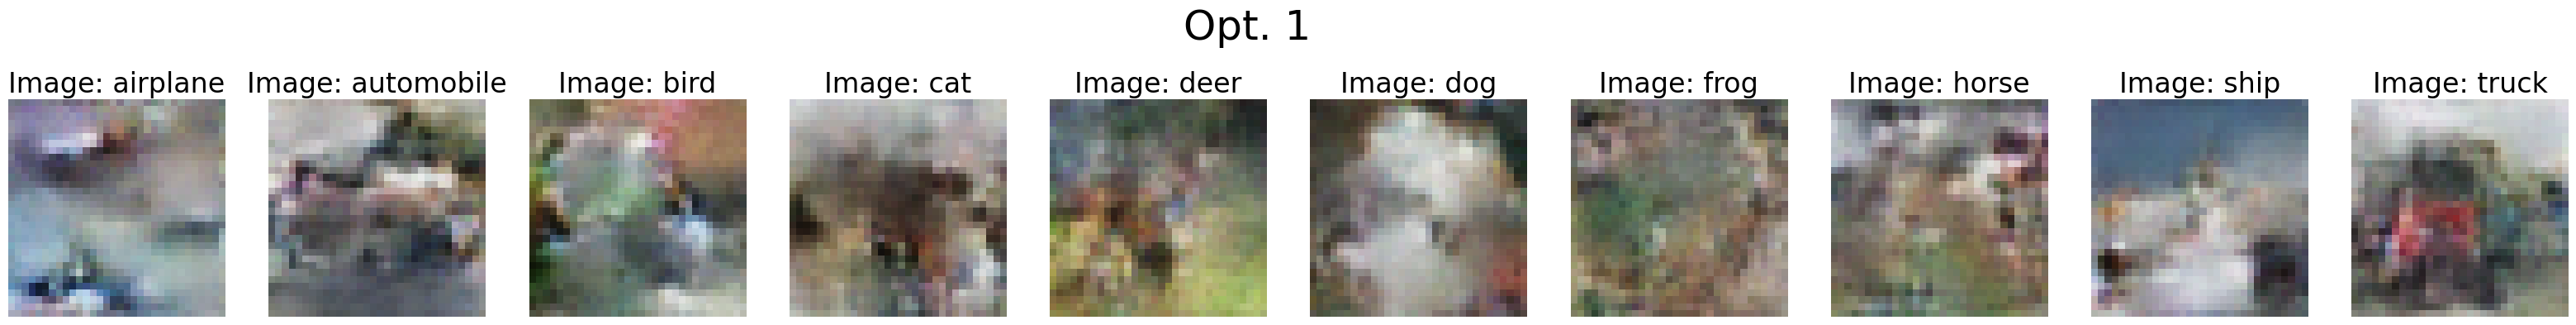

{'class_rel_acc': 1.2142713037114978,
 'fid': 128.692011025412,
 'fid_inf': 116.2814152836751}

models_save_space/gan_2


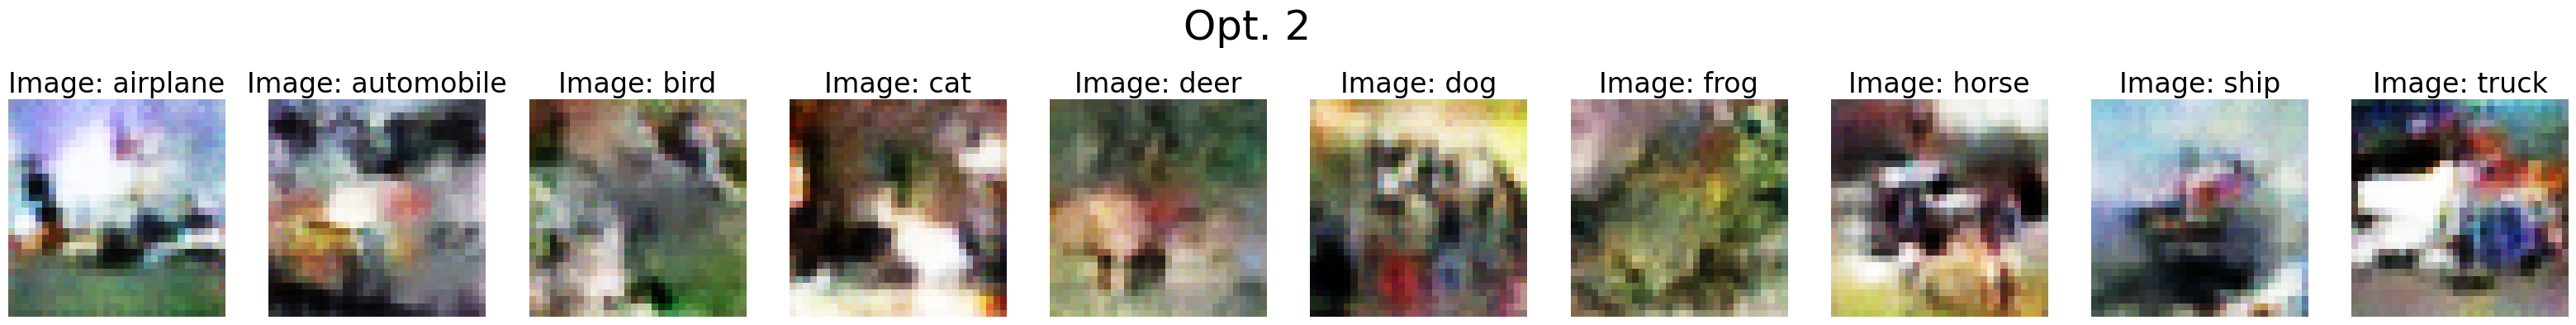

{'class_rel_acc': 1.1426675442334873,
 'fid': 126.22592345019561,
 'fid_inf': 116.60068836149544}

models_save_space/gan_3


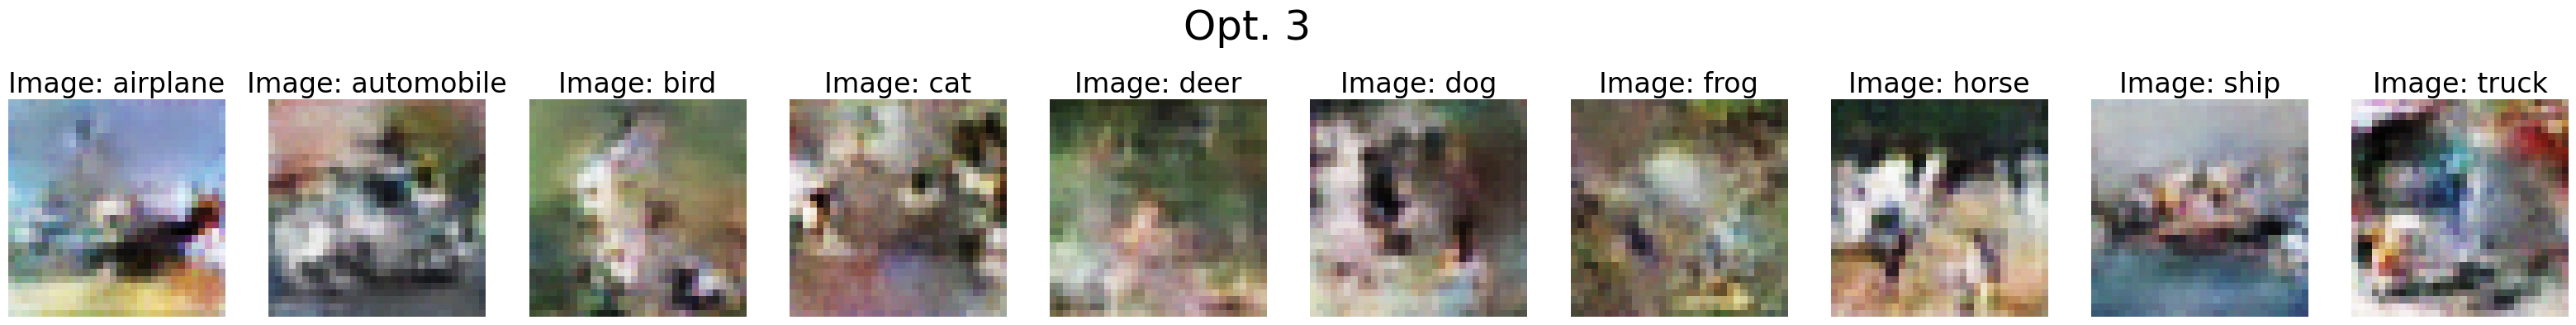

{'class_rel_acc': 1.188031207006298,
 'fid': 124.07119314487609,
 'fid_inf': 114.08027837387976}

models_save_space/gan_4


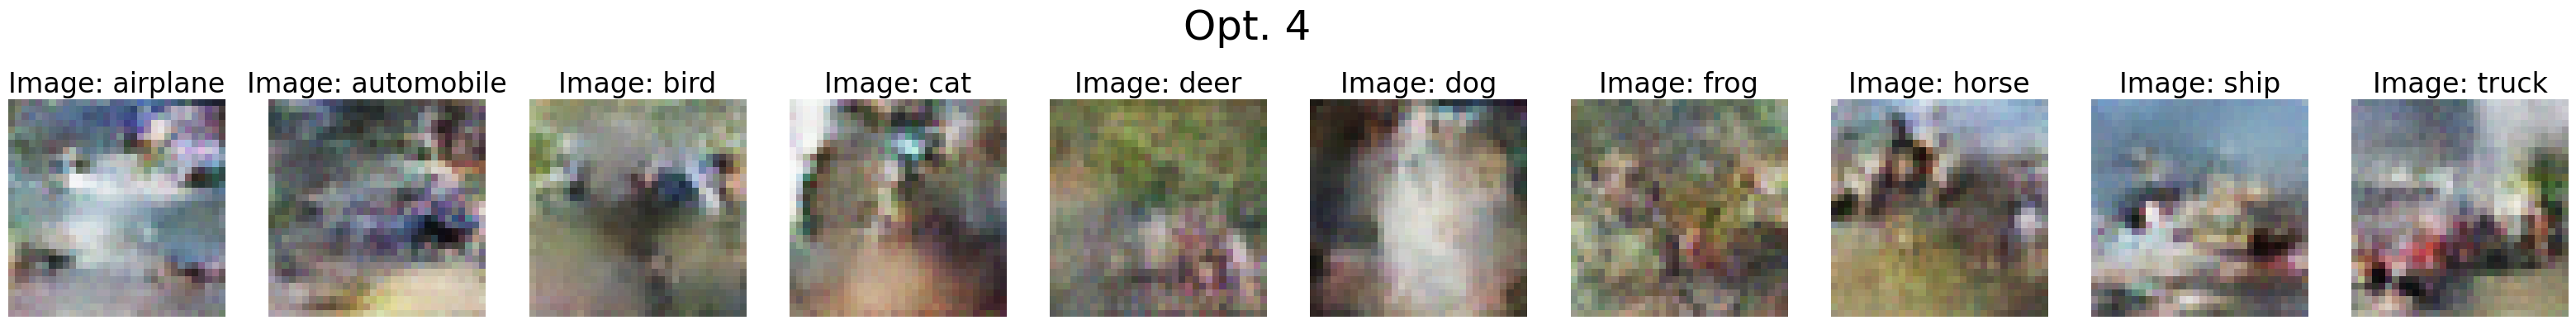

{'class_rel_acc': 1.222566911762803,
 'fid': 162.70908599871453,
 'fid_inf': 152.449967064077}

In [26]:
scripted_models = True # saves space for sharing on git
if scripted_models:
    model_path_list = ['models_save_space/gan_1', 'models_save_space/gan_2', 'models_save_space/gan_3', 'models_save_space/gan_4']
    model_save_type = "scripted"
else:
    model_path_list = ['models/gan_1', 'models/gan_2', 'models/gan_3', 'models/gan_4']
    model_save_type = "state_dict"


if not recalculate_results: # just to tidy up some parameters for the plotting
        other_params = {'input_size' : 150, 'n_layers_gen' : 5}

gen_models = {}
for i, model_path in enumerate(model_path_list):
    gen_model = {}
    for label in cifar10_classes:
        ### Need to do this preamble for the load_model function
        #net_generator = gan_utils.Generator().apply(gan_utils.weights_init)
        #optimizer_generator = optim.Adam(net_generator.parameters(), lr=2e-4, betas=(.5, .999))
        #net_generator, optimizer_generator, epoch = gan_utils.load_model(path_to_model, net_generator, optimizer_generator)
        if scripted_models:
            path_to_model = f"{model_path}/label_{label}/generator_scripted.pth"
            gen_model[label] = torch.load(path_to_model, map_location=device)
            # gen_model[label] = torch.jit.load(path_to_model, map_location=device)

        else:
            path_to_model = f"{model_path}/label_{label}/model/dcgan_generator_{model_version}.pth"
            gen_model[label] = torch.load(path_to_model, map_location=device)

    print(model_path)
    utils.plot_gan_output(gen_model, n_syn = 1, label_dict=label_dict, nn_input_size=other_params['input_size'], model_save_type = model_save_type,
                                nn_n_layers_gen=other_params['n_layers_gen'], model_type="v2", n_classes=n_classes, seed = 42, man_title = f"Opt. {i+1}")


    test_scores_json_path = f"{model_path}/test_scores.json"
    scores_summary_dict = json.load(open(test_scores_json_path, 'r'))

    this_score = (scores_summary_dict["mean"] if "mean" in scores_summary_dict.keys() else scores_summary_dict)
    display(this_score)

    gen_models[i+1] = gen_model

    # full_scores_set[model_path] = this_score

### Plot the output samples of two top models

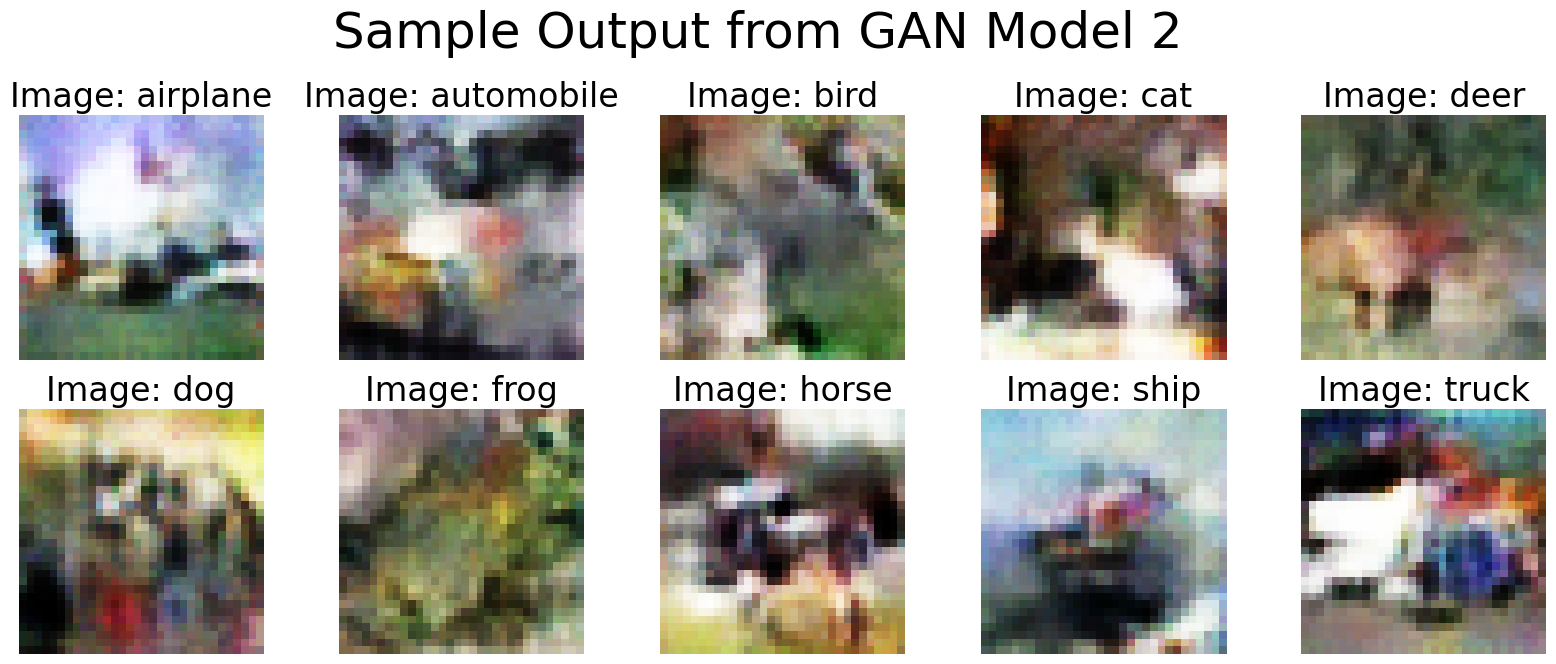

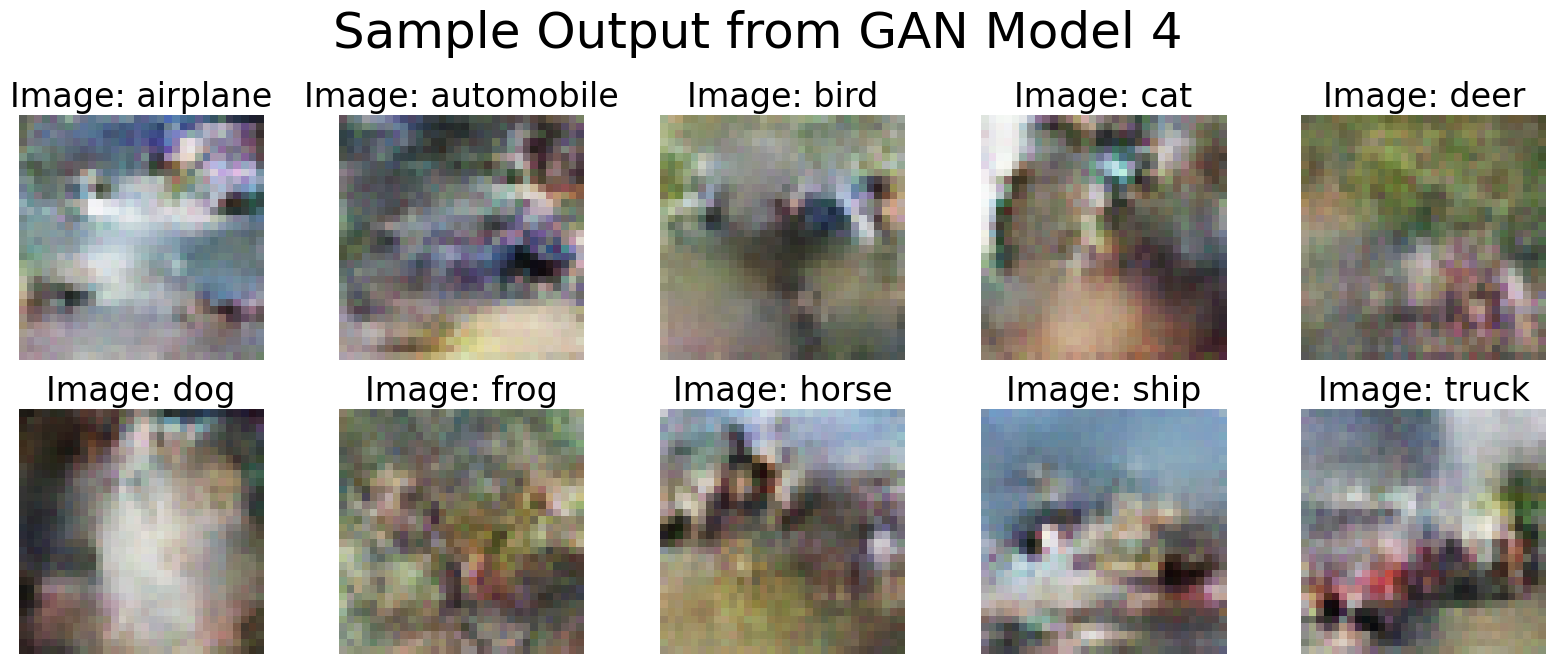

In [27]:
utils.plot_gan_output(gen_models[2], n_syn = 1, label_dict=label_dict, nn_input_size=other_params['input_size'], nn_n_layers_gen=other_params['n_layers_gen'], 
    model_type="v2", n_classes=n_classes, seed = 42, man_title = "Sample Output from GAN Model 2", wrap_single = True, model_save_type = model_save_type)

utils.plot_gan_output(gen_models[4], n_syn = 1, label_dict=label_dict, nn_input_size=other_params['input_size'], nn_n_layers_gen=other_params['n_layers_gen'], 
    model_type="v2", n_classes=n_classes, seed = 42, man_title = "Sample Output from GAN Model 4", wrap_single = True, model_save_type = model_save_type)

## Accuracy vs FID
### Conventional SD

In [35]:
reps = 5
gammas = [1, 2, 2.5, 3, 4, 5]
alphas = [3, 5, 7, 9]

fid_acc_conv_acc_score_path = "scores/fid_vs_traug_multirun_accs.json"
fid_acc_conv_fid_score_path = "scores/fid_vs_traug_multirun_fids.json"

if recalculate_results:
    all_acc_inds_per_rep = {}
    all_fid_infs_per_rep = {}
    for rep in range(reps):
        t00 = time.time()
        accs_per_var = {}
        fids_per_var = {}
        for j, gamma in enumerate(gammas):
            acc_per_aug = []
            acc_ind_per_aug = []
            fid_inf_per_aug = []
            for i, alpha in enumerate(alphas):

                t0 = time.time()
                print(f"Progress :: Calculating scores for aug var {j+1} of {len(gammas)} and ratio {i+1} of {len(alphas)} and rep {rep+1} of {reps}.")
                # I want to manually do my augmenting, so I can use the same set for the classifier-augmenting, and for the FID calculation
                real_size = len(subset_train_dataset)
                aug_size = int(np.floor(real_size * alpha - real_size))
                random_sampler = RandomSampler(subset_train_dataset, replacement=False, num_samples=aug_size)
                aug_dataloader = DataLoader(subset_train_dataset, batch_size=1, sampler=random_sampler)
                aug_imgs = []
                aug_labels = []
                for img, label in aug_dataloader:
                    new_img = utils.img_transformation(img, prob = 1, gamma = gamma)
                    aug_imgs += [new_img.squeeze(0)]; aug_labels += [label]
                aug_data = TensorDataset(torch.stack(aug_imgs), torch.tensor(aug_labels))
                aug_train_data = ConcatDataset([subset_train_dataset, aug_data])

                print(f"Progress :: Calculating classifier accuracy")
                #ti = time.time(); print(f"Time since last update = {round((ti-t0)/60, 1)} minutes."); t0 = time.time()

                cnn_mod = utils.Cifar_CNN(num_channels = 3, classes = 10, dropout_conv = dropout_conv, dropout_fc = dropout_fc).to(device)
                _, _, real_acc = utils.nn_trainer(cnn_mod, aug_train_data, test_dataset, device_str = device_name, verbose = False, 
                                            CNN_params_dict=CNN_params_dict, augmentation = False)
                
                print(f"Progress :: Calculating FID_inf")
                #ti = time.time(); print(f"Time since last update = {round((ti-t0)/60, 1)} minutes."); t0 = time.time()

                fid_inf_score = utils.calculate_FID_infinity_array(images_samp, torch.stack(aug_imgs), min_fake = 500)

                acc_per_aug += [real_acc]
                acc_ind_per_aug += [real_acc/avg_baseline_accuracy]
                fid_inf_per_aug += [fid_inf_score]
                t1 = time.time()
                print(f"    That took {(t1-t0)/60:.1f} minutes")
                
            accs_per_var[gamma] = acc_ind_per_aug
            fids_per_var[gamma] = fid_inf_per_aug
        all_acc_inds_per_rep[rep] = accs_per_var
        all_fid_infs_per_rep[rep] = fids_per_var
        t11 = time.time()
        print(f"That rep took {(t11-t00)/60:.1f} minutes")

        json.dump(all_acc_inds_per_rep, open(fid_acc_conv_acc_score_path, "w"))
        json.dump(all_fid_infs_per_rep, open(fid_acc_conv_fid_score_path, "w"))

In [36]:
aug_vars = [1, 2, 2.5, 3, 4, 5]
aug_ratios = [3, 5, 7, 9]


all_acc_inds_per_rep = json.load(open(fid_acc_conv_acc_score_path, "r"))
all_fid_infs_per_rep = json.load(open(fid_acc_conv_fid_score_path, "r"))

# Function to calculate median for each key in a nested dictionary
def calculate_median(data):
    # Firstly reshape data so that the fields we want to aggregate across are on the inside of the dict
    try:
        reshaped_data = {key: {} for key in data[0].keys()}
    except KeyError:
        reshaped_data = {key: {} for key in data["0"].keys()}
    for outer_key, inner_dict in data.items():
        for inner_key, values in inner_dict.items():
            reshaped_data[inner_key][outer_key] = values
    # Then calculate the medians on the inner dicts
    median_dict = {key: None for key in reshaped_data.keys()}
    for aug_var, inner_dict in reshaped_data.items():
        median_dict[aug_var] = list(np.median(np.array(list(inner_dict.values())).T, axis=1))
    return median_dict

# Calculate medians for all_acc_inds_per_rep and all_fid_infs_per_rep dataframes
median_accs = calculate_median(all_acc_inds_per_rep)
median_fids = calculate_median(all_fid_infs_per_rep)

full_med_fids = []
full_med_accs = []
full_med_ratios = []
full_med_vars = []
for i, (aug_var, fids) in enumerate(median_fids.items()):
    full_med_fids += fids
    full_med_accs += median_accs[aug_var]
    full_med_ratios += aug_ratios
    full_med_vars += [aug_vars[i]]*len(fids)
med_plot_df = pd.DataFrame({"fids": full_med_fids, "accs": full_med_accs, "aug_ratio": full_med_ratios, "aug_var": full_med_vars})

med_plot_df = med_plot_df.rename(columns={"aug_var":"aug_intns"})
med_plot_df = med_plot_df.rename(columns={"aug_ratio":"α", "aug_intns":"γ"})

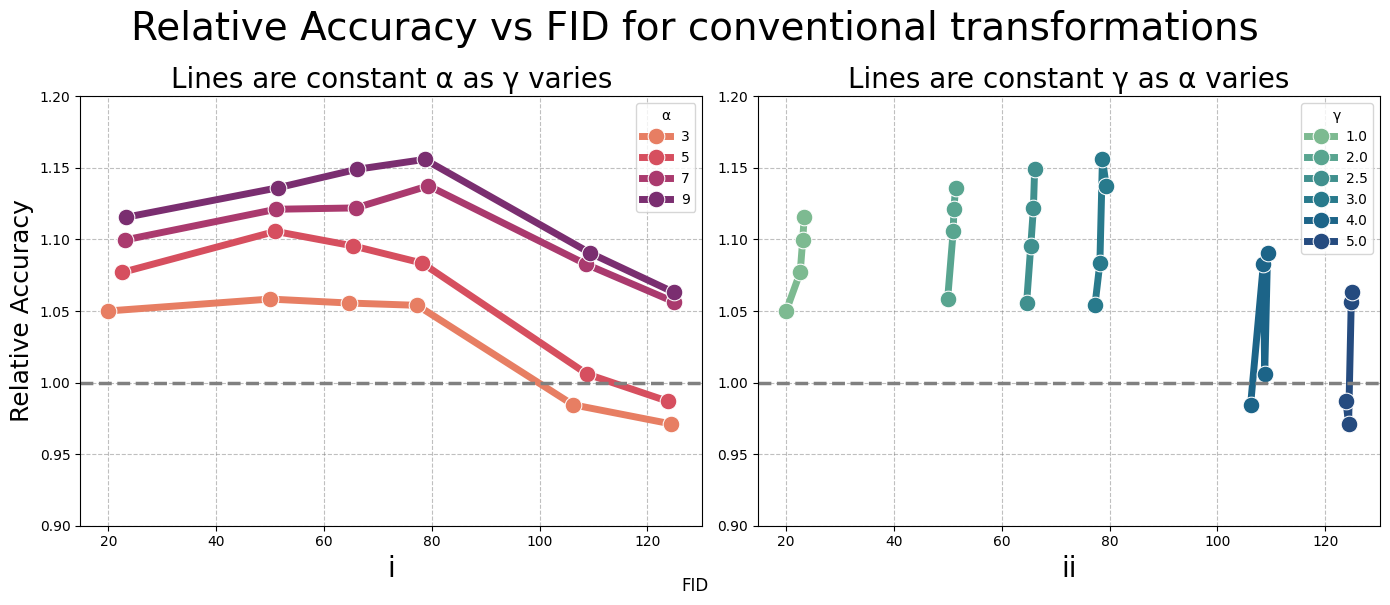

In [37]:
# Create a figure with two subplots side by side
ylim = [0.9, 1.2]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Plot 1: Constant Alpha (varying Gamma)
sns.lineplot(ax=axes[0], data=med_plot_df, x='fids', y='accs', hue='α', marker='o', markersize = 12, linewidth = 5, palette=sns.color_palette("flare", n_colors=4))
axes[0].set_title('Lines are constant α as γ varies', fontsize = 20)
axes[0].set_xlabel('i', fontsize = 20)
axes[0].set_ylabel('Relative Accuracy', fontsize = 18)
axes[0].legend(title='α')
axes[0].grid(True, which='both', linestyle='--', color='gray', alpha=0.5)  # Faint and dashed grid
axes[0].axhline(y=1, color='gray', linestyle='--', lw = 2.5)
axes[0].set_ylim(ylim)

# Plot 2: Constant Gamma (varying Alpha)
sns.lineplot(ax=axes[1], data=med_plot_df, x='fids', y='accs', hue='γ', marker='o', markersize = 12, linewidth = 5, palette=sns.color_palette("crest"))
axes[1].set_title('Lines are constant γ as α varies', fontsize = 20)
axes[1].set_xlabel('ii', fontsize = 20)
axes[1].set_ylabel('', fontsize = 18)
axes[1].legend(title='γ')
axes[1].grid(True, which='both', linestyle='--', color='gray', alpha=0.5)  # Faint and dashed grid
axes[1].axhline(y=1, color='gray', linestyle='--', lw = 2.5)
axes[1].set_ylim(ylim)

# Adjust the layout to make space between subplots
plt.suptitle("Relative Accuracy vs FID for conventional transformations", fontsize = 28)
fig.text(0.5, 0.02, 'FID', ha='center', va='center', fontsize=12)
plt.tight_layout()
plt.show()


### ImageGPT

### ??GANs??

## Accuracy vs alpha
### Conventional vs ImageGPT

### Conventional vs GAN

### ??All together with real-only??